In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

from algo_sample import *
from algo_tom import *
from algo_utils import *
# import talib

# show float in two decimal form
plt.style.use('ggplot')
pd.set_option('display.float_format',lambda x : '%.2f' % x)

In [9]:
vic = pd.read_csv("../../data/vic_train.csv")
vic = vic.loc[1:].reset_index(drop=True)
vic['time'] = vic['time'].astype('datetime64[ns]')
vic['year'] = vic['time'].dt.year
#vic.index = vic.time
#vic = vic.drop(columns='time')

vic_cv = pd.read_csv("../../data/vic_cv.csv")
vic_cv = vic_cv.loc[1:].reset_index(drop=True)
vic_cv['time'] = vic_cv['time'].astype('datetime64[ns]')
vic_cv['year'] = vic_cv['time'].dt.year
#vic_cv.index = vic_cv.time
#vic_cv = vic_cv.drop(columns='time')
vic.head()

,time,spot_price,inter_gen,demand,period,year
0,2018-01-01 00:30:00,92.46,131.68,4398,2,2018
1,2018-01-01 01:00:00,87.62,119.98,4238,3,2018
2,2018-01-01 01:30:00,73.08,123.86,4112,4,2018
3,2018-01-01 02:00:00,70.18,132.72,3956,5,2018
4,2018-01-01 02:30:00,67.43,120.73,3833,6,2018


In [10]:
def calc_a3_raw_power(percentage, forecast, opening_capacity, battery_power=BATTERY_POWER,
                      battery_capacity=BATTERY_CAPACITY, charge_efficiency=CHARGE_EFFICIENCY,
                      discharge_efficiency=DISCHARGE_EFFICIENCY):
    if (forecast == -1):
        return -min(battery_power * percentage, (battery_capacity - opening_capacity)/(charge_efficiency/100)*2)
    elif (forecast == 1):
        return min(battery_power * percentage, opening_capacity*2)
    else:
        return 0

        
def init_percentage(df):
    # set all percentage to 1 if predict a charge or discharge
    df['percentage'] = 1
    columns = list(df.columns)
    forecast_idx = columns.index('forecast')
    percentage_idx = columns.index('percentage')

    arr = df.to_numpy()
    for i in range(len(arr)):
        arr_curr = arr[i]
        forecast = arr_curr[forecast_idx]
        if forecast == 0:
            arr_curr[percentage_idx] = 0
    df[:] = arr
    return df

def compute_algo(df):
    """
    Notes: Compute forecast using algorithm 3 raw power function
    ----------
    Parameters
    ----------
    df    : dataframe with spot_price & forecast columns
    Returns
    -------
    df    : dataframe
    """
    df = df.copy(deep=False)

    # create columns
    df['raw_power'] = 0
    df['market_dispatch'] = 0
    df['market_revenue'] = 0
    df['closing_capacity'] = 0

    # get column index
    columns = list(df.columns)
    spot_price_idx = columns.index('spot_price')
    raw_power_idx = columns.index('raw_power')
    market_dispatch_idx = columns.index('market_dispatch')
    market_revenue_idx = columns.index('market_revenue')
    closing_capacity_idx = columns.index('closing_capacity')
    forecast_idx = columns.index('forecast')
    percentage_idx = columns.index('percentage')

    arr = df.to_numpy()
    for i in range(len(arr)):

        arr_curr = arr[i]
        spot_price = arr_curr[spot_price_idx]
        if i == 0:
            opening_capacity = 0
        else:
            opening_capacity = arr[i-1][closing_capacity_idx]

        forecast = arr_curr[forecast_idx]
        if forecast == 0:
            arr_curr[percentage_idx] = 0
        percentage = arr_curr[percentage_idx]

        raw_power = calc_a3_raw_power(
            percentage, forecast, opening_capacity)  # calc raw power
        market_dispatch = calc_market_dispatch(
            raw_power)  # calc market dispatch
        market_revenue = calc_market_revenue(
            market_dispatch, spot_price)  # calc market revenue
        closing_capacity = calc_closing_capacity(
            market_dispatch, opening_capacity)  # calc closing capacity

        # read value into array
        arr_curr[raw_power_idx] = raw_power
        arr_curr[market_dispatch_idx] = market_dispatch
        arr_curr[closing_capacity_idx] = closing_capacity
        arr_curr[market_revenue_idx] = market_revenue

    # replace df columns with np array
    df[:] = arr

    return df

In [11]:
# Algo Test Tom 2 (with forecast filtered & combination optimization)
df_train = vic.copy(deep=False)[['spot_price', 'period', 'year']]
df_train['forecast'] = calc_forecast_tom_2(df_train.spot_price)
df_train['forecast'] = filter_forecast(df_train.spot_price, df_train.forecast)
df_train['forecast'] = optimize_combination(df_train.spot_price, df_train.forecast)
df_train = init_percentage(df_train)
df_train = compute_algo(df_train)

print('=== Algorithm Test Tom 2 (with forecast filtered & combination optimization) ===')
print(df_train.groupby('year').market_revenue.sum())
print('Total Revenue:', df_train.market_revenue.sum())
df_test = vic_cv.copy(deep=False)[['spot_price', 'period', 'year']]
df_test['forecast'] = calc_forecast_tom_2(df_test.spot_price)
df_test['forecast'] = filter_forecast(df_test.spot_price, df_test.forecast)
df_test['forecast'] = optimize_combination(df_test.spot_price, df_test.forecast)
df_test = init_percentage(df_test)
df_test = compute_algo(df_test)
print('2021 Revenue:', df_test.market_revenue.sum(), '\n')
print("total:", df_test.market_revenue.sum()+df_train.market_revenue.sum())

=== Algorithm Test Tom 2 (with forecast filtered & combination optimization) ===
year
2018.00   30984034.00
2019.00   41407109.00
2020.00   28744880.00
Name: market_revenue, dtype: float64
Total Revenue: 101136023.0
2021 Revenue: 16885561.0 

total: 118021584.0


In [12]:
def set_percentage(df):
    # set percentage to 1 if predict a charge or discharge
    columns = list(df.columns)
    forecast_idx = columns.index('forecast')
    percentage_idx = columns.index('percentage')

    arr = df.to_numpy()
    for i in range(len(arr)):
        arr_curr = arr[i]
        forecast = arr_curr[forecast_idx]
        if forecast != 0:
            arr_curr[percentage_idx] = 1
    df[:] = arr
    return df

In [13]:
def filter_3(df):
    """
    Notes: Compute forecast using algorithm 3 raw power function
    ----------
    Parameters
    ----------
    df    : dataframe with spot_price & forecast columns
    
    Returns
    -------
    df    : dataframe
    """
#     df = pd.DataFrame({'spot_price': spot_price, 'forecast': forecast, 'org_index': org_index}).reset_index(drop = True)
    

    # get column index
    columns = list(df.columns)
    spot_price_idx = columns.index('spot_price')
    forecast_idx = columns.index('forecast')
    index_idx = columns.index('org_index')

    arr = df.to_numpy()
    i =1
    cur_df = [[0, arr[0][spot_price_idx]]]
    stop = 0 
    
    while i < len(arr):
        arr_curr = arr[i]
        spot_price = arr_curr[spot_price_idx]
    
        if (arr_curr[index_idx] != (arr[i-1][index_idx] + 1)) | (((i+1) == len(arr)) & (len(cur_df) > 1)):  # if they are continue sequence
            stop = 1
            
        
        else:
            cur_df.append([i, spot_price]) # store the current position and price
            i = i + 1

        
        # stop when not continue
        if stop == 1:
            # method 1
#             max_idx = np.argmax([item[1] for item in cur_df])
#             cur_df = cur_df[0:max_idx+1]
           
#             min_idx = np.argmin([item[1] for item in cur_df])
#             min_price  = cur_df[min_idx][1]
#             max_price = cur_df[max_idx][1]
#             dischar_idx = cur_df[max_idx][0]
#             arr[dischar_idx][forecast_idx] = 1
           
#             # choose charge price
#             if max_price >= min_price*1.26:
#                 char_idx = cur_df[min_idx][0]
#                 arr[char_idx][forecast_idx] = -1
            
            
 
           # method 2
            
#             max_idx = np.argmax([item[1] for item in cur_df])
#             cur_df = cur_df[0:max_idx+1]
           
#             min_idx = np.argmin([item[1] for item in cur_df])
#             min_price  = cur_df[min_idx][1]
#             max_price = cur_df[max_idx][1]
           
#             # choose charge price
#             if max_price >= min_price*1.26:
#                 char_idx = cur_df[min_idx][0]
#                 arr[char_idx][forecast_idx] = -1
#                 dischar_idx = cur_df[max_idx][0]
#                 arr[dischar_idx][forecast_idx] = 1

            # method 3
            if len(cur_df) > 1:

                max_idx = np.argmax([item[1] for item in cur_df])
            
            # assign max price until max pirce in the space is not the first one
                while max_idx == 0:
                    dischar_idx = cur_df[max_idx][0]
                    arr[dischar_idx][forecast_idx] = 1 # assign to 1 to avoid repeat  
                    cur_df = cur_df[max_idx+1:]
                    if len(cur_df) == 0:
                        break
                    else:
                        max_idx = np.argmax([item[1] for item in cur_df])
            
                if len(cur_df) != 0:
                    cur_df = cur_df[: max_idx+1]
                    min_idx = np.argmin([item[1] for item in cur_df])
                    min_price  = cur_df[min_idx][1]
                    max_price = cur_df[max_idx][1]
                    dischar_idx = cur_df[max_idx][0]
                    arr[dischar_idx][forecast_idx] = 1   

                # choose charge price
                    if max_price >= min_price*1.26:
                        char_idx = cur_df[min_idx][0]
                        arr[char_idx][forecast_idx] = -1
                        
#                         if max_price <= 0:
#                             arr[dischar_idx][forecast_idx] = 0
                
                # reset cur_df
            cur_df = [[i, arr[i][spot_price_idx]]]
            stop =0
            i = i+1
    
    df[:] = arr
   
    forecast = df.forecast
    return forecast.to_numpy()

In [14]:
def filter_4(df):

    # get column index
    columns = list(df.columns)
    spot_price_idx = columns.index('spot_price')
    forecast_idx = columns.index('forecast')
    index_idx = columns.index('org_index')


    arr = df.to_numpy()
    i =1
    cur_df = [[0, arr[0][spot_price_idx]]]
    stop = 0
    
    while i < len(arr):
        
        arr_curr = arr[i]
        spot_price = arr_curr[spot_price_idx]
       
        #if arr_curr[index_idx] == (arr[i-1][index_idx] + 1):  # if they are continue sequence
#             cur_df.append([i, spot_price]) # store the current position and price
#             i = i + 1


        if (arr_curr[index_idx] != (arr[i-1][index_idx] + 1)) | (((i+1) == len(arr)) & (len(cur_df) > 1)):  # if they are continue sequence
            stop = 1
              
        else:
            cur_df.append([i, spot_price]) # store the current position and price
            i = i + 1
            
        # Start from here: different from fliter 3 ==================
        if stop == 1 : 
            max_idx = np.argmax([item[1] for item in cur_df]) # find the maximum spot_price position
            cur_df = cur_df[max_idx:]
           
            min_idx = np.argmin([item[1] for item in cur_df]) # find the minimum spot_price position
            min_price  = cur_df[min_idx][1]
            max_price = cur_df[0][1]

            
            # choose charge price
            if max_price > min_price*1.26:
                char_idx = cur_df[min_idx][0]
                arr[char_idx][forecast_idx] = -1
                
                dischar_idx = cur_df[0][0]
                arr[dischar_idx][forecast_idx] = 1

        # ==========================================        
            
            # reset cur_df
            cur_df = [[i, arr[i][spot_price_idx]]]
            i = i+1
            stop = 0
    
    df[:] = arr
    forecast = df.forecast
#     print(arr)
    return forecast.to_numpy()

In [15]:
def filter_5(df):

    # get column index
    columns = list(df.columns)
    spot_price_idx = columns.index('spot_price')
    forecast_idx = columns.index('forecast')
    index_idx = columns.index('org_index')

    arr = df.to_numpy()
    i =1
    cur_df = [[0, arr[0][spot_price_idx]]]
    stop = 0
    while i < len(arr):
        
        arr_curr = arr[i]
        spot_price = arr_curr[spot_price_idx]
       
         #if arr_curr[index_idx] == (arr[i-1][index_idx] + 1):  # if they are continue sequence
#             cur_df.append([i, spot_price]) # store the current position and price
#             i = i + 1
            
        if (arr_curr[index_idx] != (arr[i-1][index_idx] + 1)) | (((i+1) == len(arr)) & (len(cur_df) > 1)):  # if they are continue sequence
            stop = 1
            
        else:
            cur_df.append([i, spot_price]) # store the current position and price
            i = i + 1
            
        # stop when not continue
        # Start from here: different from fliter 4 ==================
        if stop == 1:
            max_difference = 0
            max_difference_combination=[]
            for row_a in cur_df:
                for row_b in cur_df: # check is there an decreasing trend
                    if (row_a[0] < row_b[0]) and (row_a[1] > row_b[1]*1.26) and ((row_a[1] - row_b[1])> max_difference):
                        max_difference = row_a[1] - row_b[1]
                        max_difference_combination = [row_a, row_b]

            if len(max_difference_combination) > 0:
                dischar_idx = max_difference_combination[0][0]
                char_idx = max_difference_combination[1][0]

                arr[char_idx][forecast_idx] = -1
                arr[dischar_idx][forecast_idx] = 1
            

        # ==============================================================
                           
            # reset cur_df
            cur_df = [[i, arr[i][spot_price_idx]]]
            i = i+1
            stop = 0
    

    df[:] = arr
    forecast = df.forecast
#     print(arr)
    return forecast.to_numpy()

In [16]:
def filter_6(df):

    # get column index
    columns = list(df.columns)
    spot_price_idx = columns.index('spot_price')
    forecast_idx = columns.index('forecast')
    index_idx = columns.index('org_index')

    arr = df.to_numpy()
    i =1
    cur_df = [[0, arr[0][spot_price_idx]]]
    stop = 0
    while i < len(arr):
        
        arr_curr = arr[i]
        spot_price = arr_curr[spot_price_idx]
       
         #if arr_curr[index_idx] == (arr[i-1][index_idx] + 1):  # if they are continue sequence
#             cur_df.append([i, spot_price]) # store the current position and price
#             i = i + 1

        if (arr_curr[index_idx] != (arr[i-1][index_idx] + 1)) | (((i+1) == len(arr)) & (len(cur_df) > 1)):  # if they are continue sequence
            stop = 1
            
        else:
            cur_df.append([i, spot_price]) # store the current position and price
            i = i + 1
        
        # stop when not continue
        # Start from here: different from fliter 5 ==================
        if stop ==1:
            max_difference = 0
            max_difference_combination=[]
            for row_a in cur_df:
                for row_b in cur_df: # check is there an increasing trend
                    if (row_a[0] < row_b[0]) and (row_a[1]*1.26 < row_b[1]) and ((row_b[1] - row_a[1])> max_difference):
                        max_difference = row_b[1] - row_a[1]
                        max_difference_combination = [row_a, row_b]

            if len(max_difference_combination) > 0:
                dischar_idx = max_difference_combination[1][0]
                char_idx = max_difference_combination[0][0]

                arr[char_idx][forecast_idx] = -1
                arr[dischar_idx][forecast_idx] = 1
            

        # ==============================================================
                           
            # reset cur_df
            cur_df = [[i, arr[i][spot_price_idx]]]
            i = i+1
            stop = 0
    

    df[:] = arr
    forecast = df.forecast
#     print(arr)
    return forecast.to_numpy()

In [17]:
def set_percentage_for_fliter45(df, discharge_per, charge_per = 0.89):
    
    columns = list(df.columns)
    forecast_idx = columns.index('forecast')
    percentage_idx = columns.index('percentage')

    arr = df.to_numpy()
    for i in range(len(arr)):
        arr_curr = arr[i]
        forecast = arr_curr[forecast_idx]
        percentage = arr_curr[percentage_idx]

        # set percentage to 0.9 if discharge occurs in the fliter 5
        if (forecast == 1) and (percentage == 0):
            arr_curr[percentage_idx] = charge_per


        # set percentage to 1 if charge occurs in the fliter 5
        if (forecast == -1) and (percentage == 0):
            arr_curr[percentage_idx] = discharge_per

    df[:] = arr
    return df


def set_percentage_for_fliter3(df):
    
    columns = list(df.columns)
    forecast_idx = columns.index('forecast')
    percentage_idx = columns.index('percentage')

    arr = df.to_numpy()
    for i in range(len(arr)):
        arr_curr = arr[i]
        forecast = arr_curr[forecast_idx]
        percentage = arr_curr[percentage_idx]

        # set percentage to 1 if discharge occurs in the fliter 3
        if (forecast == 1) and (percentage == 0):
            arr_curr[percentage_idx] = 1


        # set percentage to 1 if charge occurs in the fliter 3
        if (forecast == -1) and (percentage == 0):
            arr_curr[percentage_idx] = 1

    df[:] = arr
    return df


In [18]:
def optimize_combination(spot_price, forecast):
    """
    Notes: Maximise profit by tracking capacity and select the best combination of discharge and charge
    Problem: The 1st and 2nd time return different results (2nd slightly lower revenue), and remain the same afterwards
    ----------
    Parameters
    ----------
    spot_price  : Spot price series
    forecast    : forecast series

    Returns
    -------
    forecast    : forecast series
    """

    BATTERY_CAPACITY = 580
    MAX_DISCHARGE = 150
    MAX_CHARGE = -135
    capacity = 0

    df = pd.DataFrame(
        {'spot_price': spot_price, 'forecast': forecast}).reset_index(drop=True)
    idx_spot_price = 0
    idx_forecast = 1

    dict_forecast = {'charge': [], 'discharge': [], 'remaining': []}
    # 'charge', 'discharge', 'reamining': [index, spot_price, market_dispatch]
    idx_dict_spot_price = 1
    idx_dict_market_dispatch = 2

    arr = df[df.forecast != 0].to_numpy()
    for i in range(len(arr)):
        arr_curr = arr[i]

        # if charge signal
        if arr_curr[idx_forecast] < 0:

            # first settle previous charge and discharge
            if len(dict_forecast['discharge']) > 0:
                # we need to sort charge and discharge position so
                # we can sell the lowest charge at the higest price
                dict_forecast['charge'].sort(
                    key=lambda x: x[idx_dict_spot_price])
                dict_forecast['discharge'].sort(
                    key=lambda x: x[idx_dict_spot_price], reverse=True)

                # sell remaining position first if available
                if len(dict_forecast['remaining']) > 0:
                    total_remaining = np.array(dict_forecast['remaining'])[
                        :, idx_dict_market_dispatch].sum()
                    dict_forecast['discharge'][0][idx_dict_market_dispatch] += total_remaining
                    capacity += total_remaining
                    dict_forecast['remaining'] = []

                # sell discharge position if available
                for j in range(len(dict_forecast['discharge'])):
                    discharge_curr = dict_forecast['discharge'][j]

                    for k in range(len(dict_forecast['charge'])):
                        charge_curr = dict_forecast['charge'][k]

                        discharge_curr[idx_dict_market_dispatch] += charge_curr[idx_dict_market_dispatch]
                        capacity += charge_curr[idx_dict_market_dispatch]

                        # regular charge
                        if discharge_curr[idx_dict_market_dispatch] >= 0:
                            charge_curr[idx_dict_market_dispatch] = 0

                        # if it is fully discharged and have remaining charge,
                        # give charge back to dict_forecast_charge
                        else:
                            charge_curr[idx_dict_market_dispatch] = discharge_curr[idx_dict_market_dispatch]
                            discharge_curr[idx_dict_market_dispatch] = 0
                            capacity -= charge_curr[idx_dict_market_dispatch]

                            # if the last discharge was completed and has remaining charge, give it priority to sell next time
                            # by moving it to remaining list and remove from original list
                            if (j == len(dict_forecast['discharge']) - 1):
                                dict_forecast['remaining'].append(charge_curr)
                                dict_forecast['charge'].pop(k)
                            break

                # remove empty charge position
                charge_position_new = []
                for j in range(len(dict_forecast['charge'])):
                    market_dispatch = dict_forecast['charge'][j][idx_dict_market_dispatch]
                    if market_dispatch < 0:
                        charge_position_new.append(dict_forecast['charge'][j])
                dict_forecast['charge'] = charge_position_new

                # discharge complete, remove discharge from dict
                # and set discharge forcast to zero if nothing had done
                for j in range(len(dict_forecast['discharge'])):
                    if dict_forecast['discharge'][j][idx_dict_market_dispatch] == MAX_DISCHARGE:
                        idx = dict_forecast['discharge'][j][0]
                        arr[idx][idx_forecast] = 0
                dict_forecast['discharge'] = []

            # add charge position to dict
            opening_capacity = capacity
            capacity = min(BATTERY_CAPACITY, capacity - MAX_CHARGE)
            capacity = max(0, capacity)
            market_dispatch = opening_capacity - capacity

            # if current capacity is not full, charge regularly
            if market_dispatch < 0:
                dict_forecast['charge'].append(
                    [i, arr_curr[idx_spot_price], market_dispatch])

            # if current capacity is full, replace the highest spot price charge position
            else:
                # replace iff current spot price is lower than the highest one in dict
                dict_forecast['charge'].sort(
                    key=lambda x: x[idx_dict_spot_price])
                if arr_curr[idx_spot_price] < dict_forecast['charge'][-1][idx_dict_spot_price]:
                    market_dispatch = dict_forecast['charge'][-1][idx_dict_market_dispatch]
                    idx = dict_forecast['charge'][-1][0]
                    arr[idx][idx_forecast] = 0
                    dict_forecast['charge'].pop()
                    dict_forecast['charge'].append(
                        [i, arr_curr[idx_spot_price], market_dispatch])

        # if discharge signal
        if arr_curr[idx_forecast] > 0:
            dict_forecast['discharge'].append(
                [i, arr_curr[idx_spot_price], MAX_DISCHARGE])

    # replace df columns with np array
    df[df.forecast != 0] = arr

    forecast = df.forecast

    return forecast.to_numpy()

In [26]:

start = 30510  #30455
end = 30560 #30555

In [30]:
np.round(-14.5)

-14.0

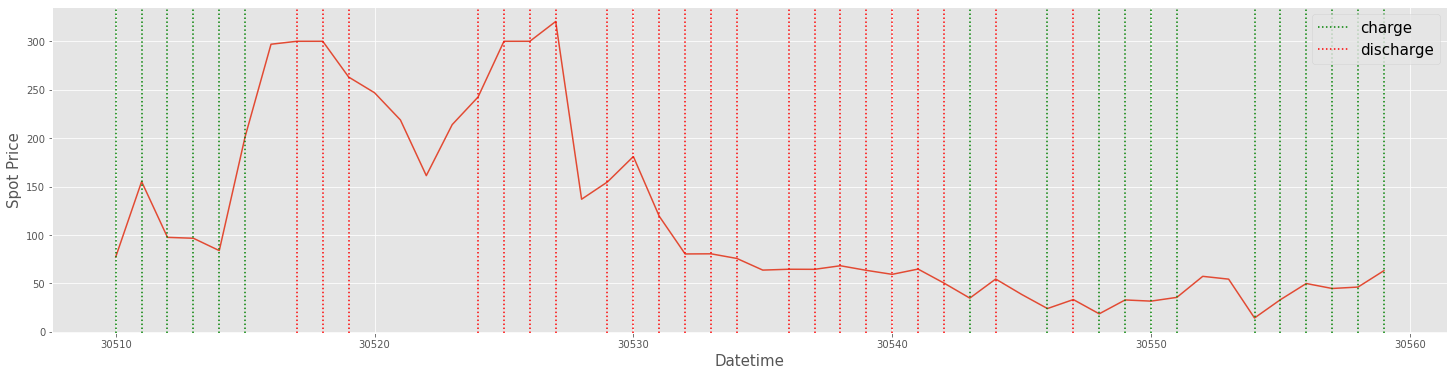

==== Before fliter ====


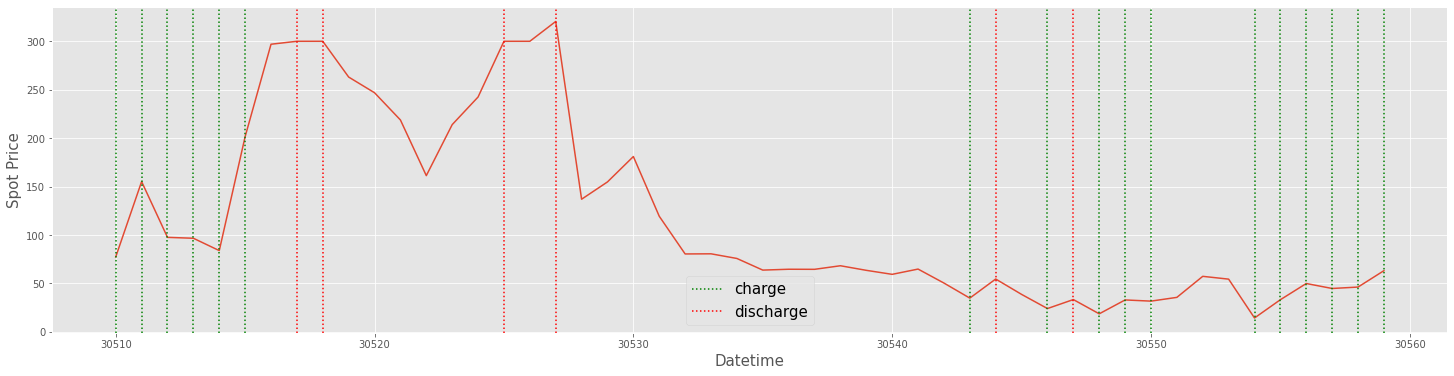

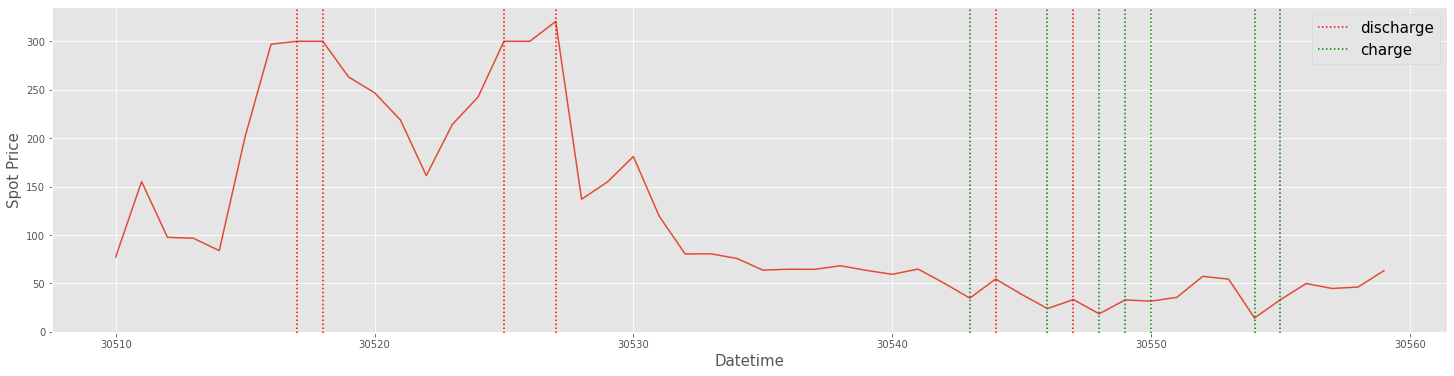

In [29]:
# Algo Test Tom 2 (with forecast filtered & combination optimization)
df_train = vic.copy(deep=False)[['spot_price', 'period', 'year']]
df_train['forecast'] = calc_forecast_tom_2(df_train.spot_price)
plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)

# two base filter
# df_train['forecast'] = filter_forecast(df_train.spot_price, df_train.forecast)
# plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)

df_train['forecast'] = optimize_combination(df_train.spot_price, df_train.forecast)
# plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)

# big boss
# market_dispatch, forecast = optimize_dispatch(df_train.spot_price, df_train.forecast)
# df = pd.DataFrame({'spot_price': df_train.spot_price, 'market_dispatch': market_dispatch, 'forecast': forecast})
# df['market_revenue'] = 0
# for index, row in df.iterrows():
#     df.market_revenue[index] = calc_market_revenue(row.market_dispatch, row.spot_price)

# df_train['market_dispatch'] = df.market_dispatch
# df_train['forecast'] = np.where(df.market_dispatch < 0, -1, np.where(
#                                      df.market_dispatch > 0, 1,
#                                      0))

df_train = init_percentage(df_train)
df_train = compute_algo(df_train)
print("==== Before fliter ====")
plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)
plot_actions(df_train.spot_price, df_train.raw_power, start=start, end=end)

# more filter 3 =============
# for i in range(1):
    
#     space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] == 0)].iloc[:, [0,3,]]
#     space['org_index'] = space.index
#     space = space.reset_index(drop=True)
#     idx = space.org_index.to_list()
#     df_train.loc[idx, 'forecast'] = filter_3(space)

#     df_train = set_percentage_for_fliter3(df_train)
#     df_train['forecast'] = optimize_combination(df_train.spot_price, df_train.forecast)

#     df_train = compute_algo(df_train)
    
# print('Total Revenue:', df_train.market_revenue.sum())    
# print("==== fliter 3 ====")

# plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)
# plot_actions(df_train.spot_price, df_train.raw_power, start=start, end=end)

# end =========================

# more filter 4 ===============
# space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] == 580)].iloc[:, [0,3,]]
# space['org_index'] = space.index
# space = space.reset_index(drop=True)
# idx = space.org_index.to_list()
# df_train.loc[idx, 'forecast'] = filter_4(space)

# df_train = set_percentage_for_fliter45(df_train, 1)
# df_train = compute_algo(df_train)

# space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] >= 430)].iloc[:, [0,3,]]
# space['org_index'] = space.index
# space = space.reset_index(drop=True)
# idx = space.org_index.to_list()
# df_train.loc[idx, 'forecast'] = filter_4(space)
# # end =============
# print("==== fliter 4 ====")
# plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)
# plot_actions(df_train.spot_price, df_train.raw_power, start=start, end=end)

# df_train = set_percentage_for_fliter45(df_train, 0.985)
# df_train = compute_algo(df_train)
    
# for i in range(3):
#     # more filter 5 ===============
#     space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] >= 135)].iloc[:, [0,3,]]
#     space['org_index'] = space.index
#     space = space.reset_index(drop=True)
#     idx = space.org_index.to_list()
#     df_train.loc[idx, 'forecast'] = filter_5(space)

#     df_train = set_percentage_for_fliter45(df_train, 1)
#     df_train = compute_algo(df_train)
#     # end =============
# print('Total Revenue:', df_train.market_revenue.sum())    
# print("==== fliter 5 ====")

# plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)
# # end =========================


In [16]:
df_train.loc[30510:30560]
#101534210.0.0
#101486831.0
#101631036.0.0

,spot_price,period,year,forecast,percentage,raw_power,market_dispatch,market_revenue,closing_capacity
30510,77.45,32.00,2019.00,-1.00,1.00,-0.00,-0.00,-0.00,580.00
30511,155.15,33.00,2019.00,-1.00,1.00,-0.00,-0.00,-0.00,580.00
30512,97.59,34.00,2019.00,-1.00,1.00,-0.00,-0.00,-0.00,580.00
30513,96.67,35.00,2019.00,-1.00,1.00,-0.00,-0.00,-0.00,580.00
30514,83.93,36.00,2019.00,-1.00,1.00,-0.00,-0.00,-0.00,580.00
30515,201.60,37.00,2019.00,-1.00,1.00,-0.00,-0.00,-0.00,580.00
30516,296.95,38.00,2019.00,0.00,0.00,0.00,0.00,0.00,580.00
30517,299.99,39.00,2019.00,1.00,1.00,300.00,135.00,40134.00,430.00
30518,299.99,40.00,2019.00,1.00,1.00,300.00,135.00,40134.00,280.00
30519,263.07,41.00,2019.00,0.00,0.00,0.00,0.00,0.00,280.00


==== Base fliter ====


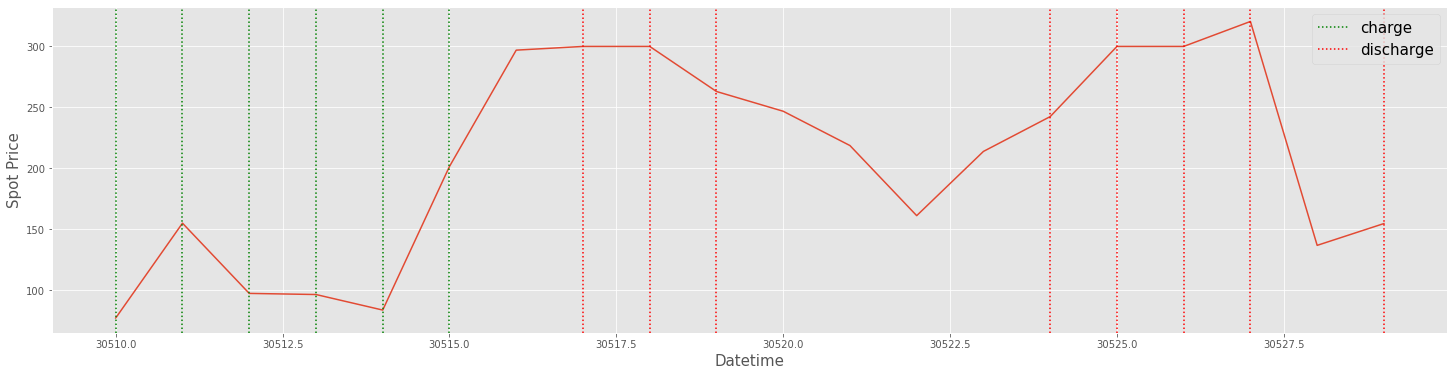

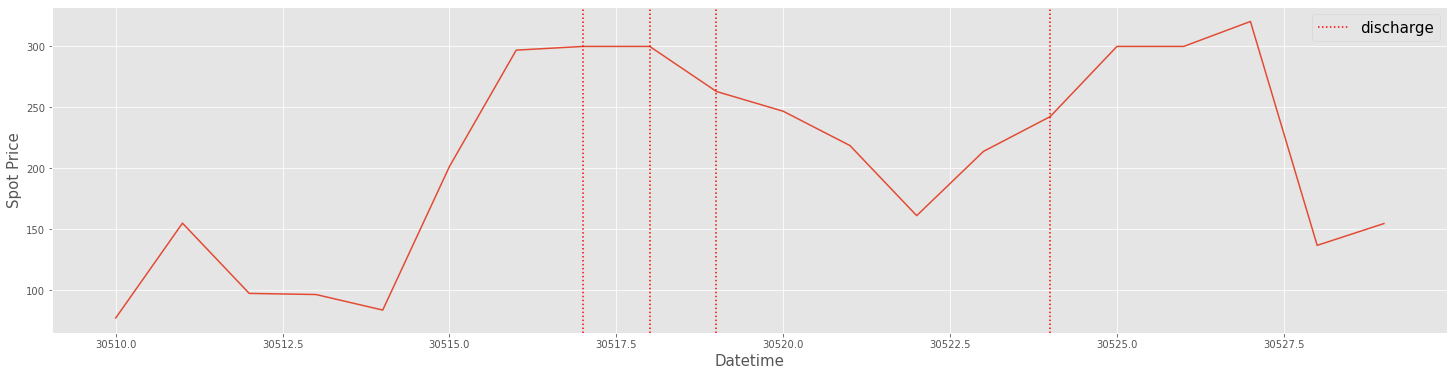

Total Revenue: 96863208.0
==== fliter 3 ====


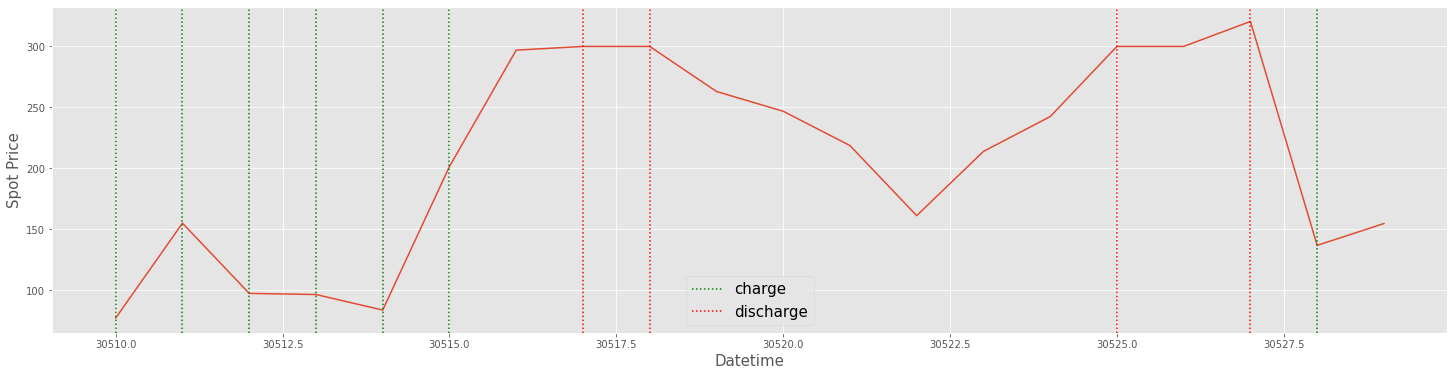

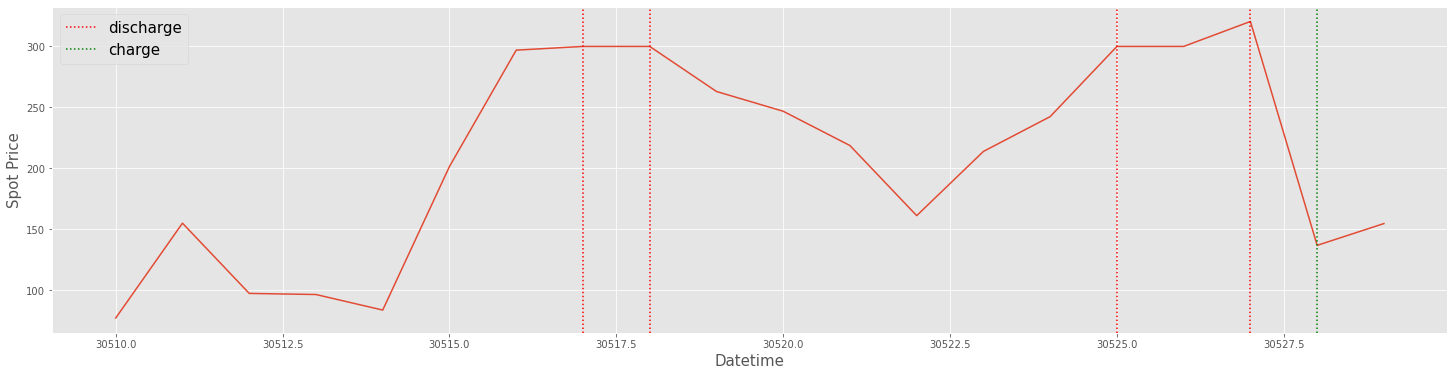

Total Revenue: 101518584.0
==== fliter 4 ====


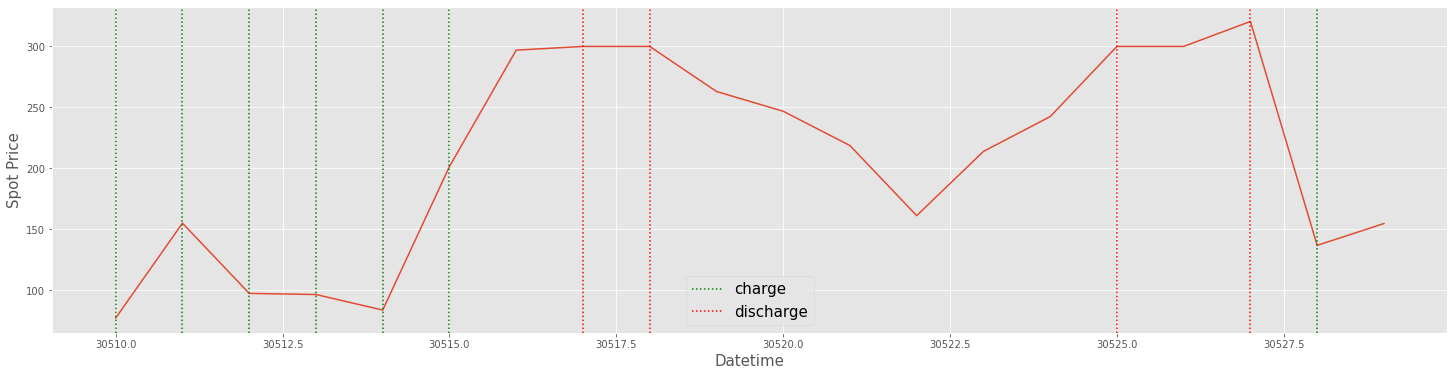

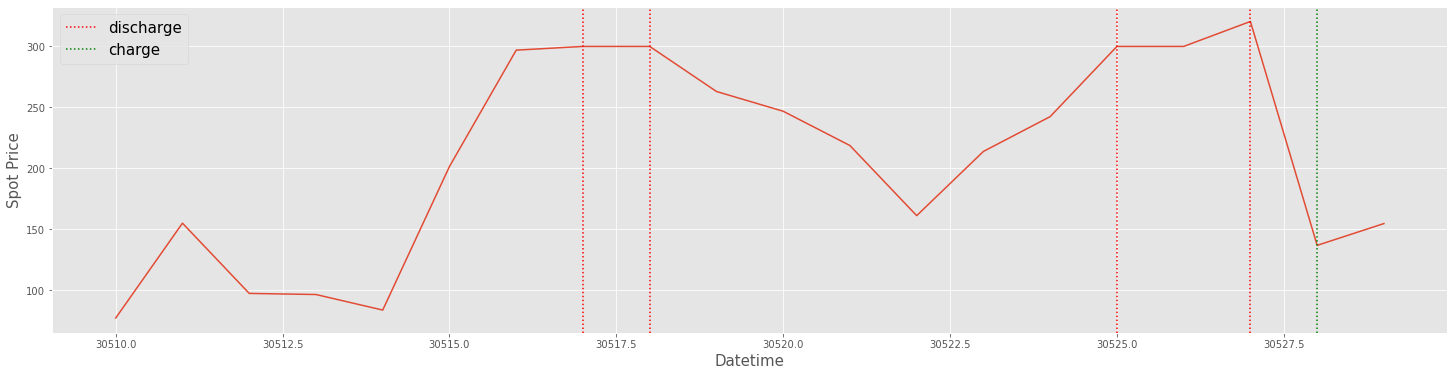

Total Revenue: 102029608.0
==== fliter 56 ====


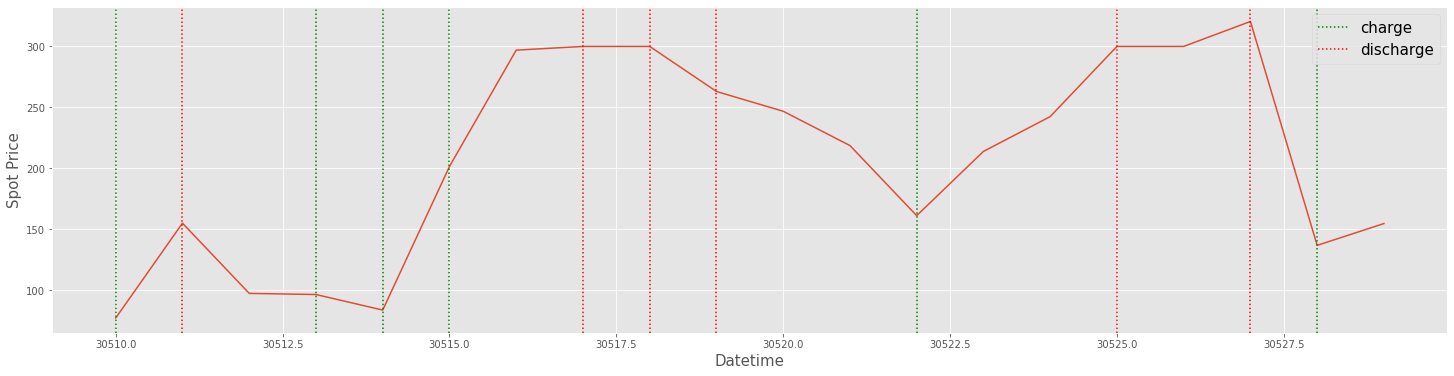

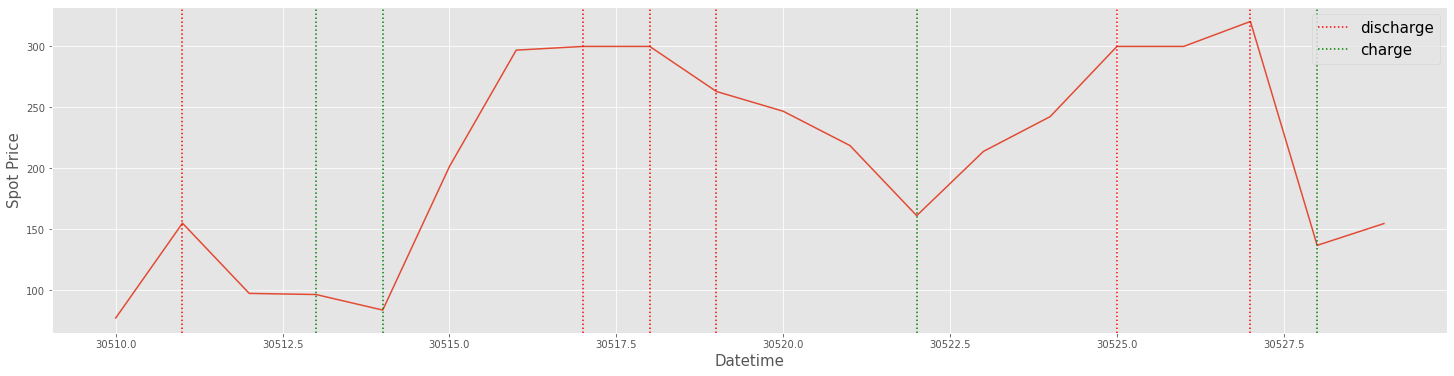

Total Revenue: 102405606.0
=== Algorithm Test Tom 2 (with forecast filtered & combination optimization) ===
==== final ====


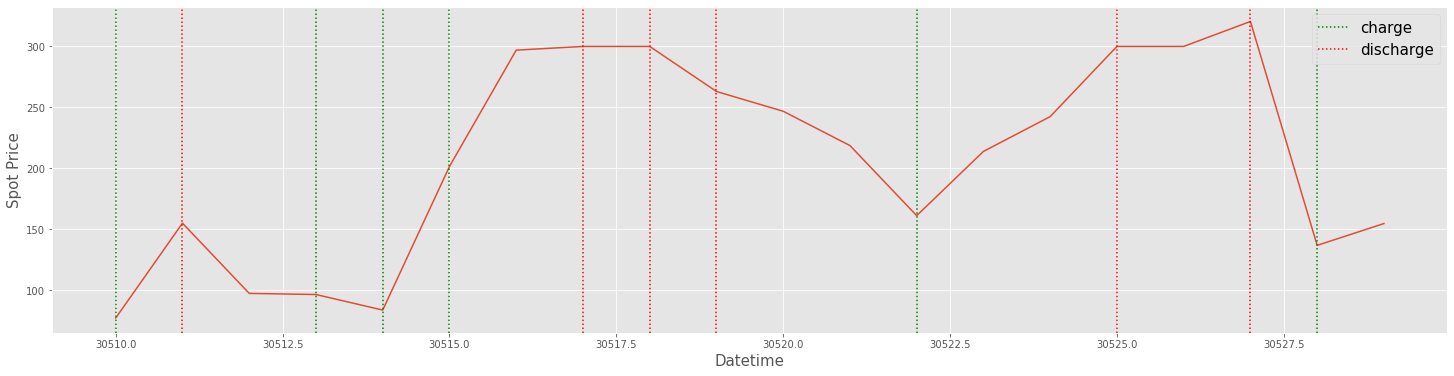

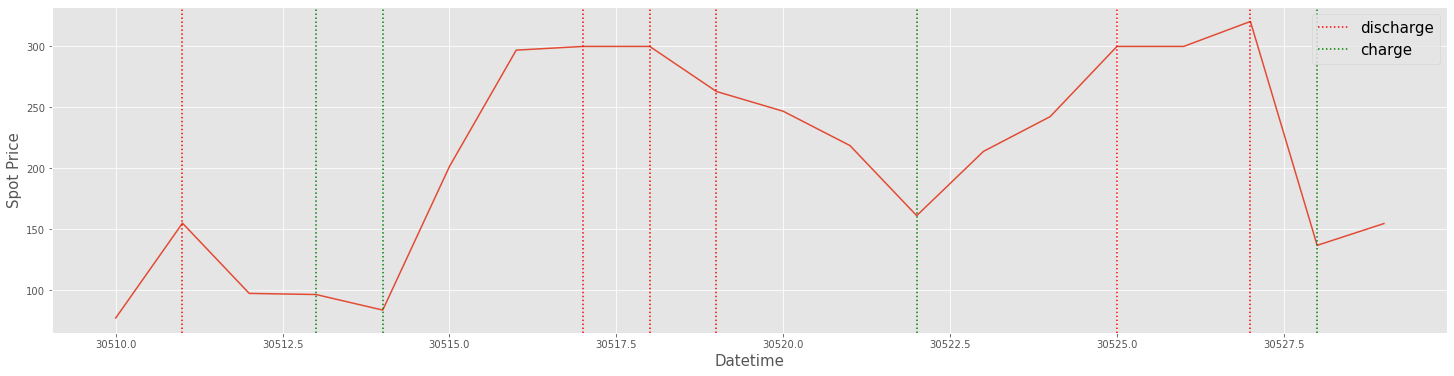

Total Revenue: 104149705.0
2021 Revenue: 17356653.0 

total: 121506358.0


In [24]:
# Algo Test Tom 2 (with forecast filtered & combination optimization)
df_train = vic.copy(deep=False)[['spot_price', 'period', 'year']]
df_train['forecast'] = calc_forecast_tom_2(df_train.spot_price)
# plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)

# df_train['forecast'] = filter_forecast(df_train.spot_price, df_train.forecast)
# plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)

# df_train['forecast'] = optimize_combination(df_train.spot_price, df_train.forecast)
# plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)

# market_dispatch, forecast = optimize_dispatch(df_train.spot_price, df_train.forecast)
# df = pd.DataFrame({'spot_price': df_train.spot_price, 'market_dispatch': market_dispatch, 'forecast': forecast})
# df['market_revenue'] = 0
# for index, row in df.iterrows():
#     df.market_revenue[index] = calc_market_revenue(row.market_dispatch, row.spot_price)

# df_train['market_dispatch'] = df.market_dispatch
# df_train['forecast'] = np.where(df.market_dispatch < 0, -1, np.where(
#                                      df.market_dispatch > 0, 1,
#                                      0))
df_train = init_percentage(df_train)
df_train = compute_algo(df_train)
print("==== Base fliter ====")
plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)
plot_actions(df_train.spot_price, df_train.raw_power, start=start, end=end)

print('Total Revenue:', df_train.market_revenue.sum())    

for i in range(3):
    # more filter 3 =============
    space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] == 0)].iloc[:, [0,3,]]
    space['org_index'] = space.index
    space = space.reset_index(drop=True)
    idx = space.org_index.to_list()
    df_train.loc[idx, 'forecast'] = filter_3(space)

    df_train['forecast'] = optimize_combination(df_train.spot_price, df_train.forecast)
    df_train = set_percentage_for_fliter3(df_train)
    df_train = compute_algo(df_train)
    # end =========================

print("==== fliter 3 ====")
plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)
plot_actions(df_train.spot_price, df_train.market_dispatch, start=start, end=end)
print('Total Revenue:', df_train.market_revenue.sum())    

# more filter 4 ===============
space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] == 580)].iloc[:, [0,3,]]
space['org_index'] = space.index
space = space.reset_index(drop=True)
idx = space.org_index.to_list()
df_train.loc[idx, 'forecast'] = filter_4(space)
df_train['forecast'] = optimize_combination(df_train.spot_price, df_train.forecast)

df_train = set_percentage_for_fliter45(df_train, 1)
df_train = compute_algo(df_train)

space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] >= 430)].iloc[:, [0,3,]]
space['org_index'] = space.index
space = space.reset_index(drop=True)
idx = space.org_index.to_list()
df_train.loc[idx, 'forecast'] = filter_4(space)
df_train['forecast'] = optimize_combination(df_train.spot_price, df_train.forecast)
# end =============
print("==== fliter 4 ====")
plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)
plot_actions(df_train.spot_price, df_train.raw_power, start=start, end=end)

df_train = set_percentage_for_fliter45(df_train, 1)
df_train = compute_algo(df_train)
print('Total Revenue:', df_train.market_revenue.sum())    


for i in range(3):
    # more filter 5 ===============
    space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] >= 135)].iloc[:, [0,3,]]
    space['org_index'] = space.index
    space = space.reset_index(drop=True)
    idx = space.org_index.to_list()
    df_train.loc[idx, 'forecast'] = filter_5(space)

    df_train['forecast'] = optimize_combination(df_train.spot_price, df_train.forecast)
    df_train = set_percentage_for_fliter45(df_train, 1)
    df_train = compute_algo(df_train)
    # end =============

for i in range(3):
    # more filter 6 ===============
    space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] == 0)].iloc[:, [0,3,]]
    space['org_index'] = space.index
    space = space.reset_index(drop=True)
    idx = space.org_index.to_list()
    df_train.loc[idx, 'forecast'] = filter_6(space)

    df_train = set_percentage_for_fliter3(df_train)
    df_train = compute_algo(df_train)
    # end =============
print("==== fliter 56 ====")
plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)
plot_actions(df_train.spot_price, df_train.raw_power, start=start, end=end)
print('Total Revenue:', df_train.market_revenue.sum())    


# df_train['forecast'] = filter_forecast(df_train.spot_price, df_train.forecast)
# df_train = compute_algo(df_train)
market_dispatch = optimize_dispatch(df_train.spot_price, df_train.forecast)
df = pd.DataFrame({'spot_price': df_train.spot_price, 'market_dispatch': market_dispatch, 'forecast': df_train.forecast})
df['market_revenue'] = calc_market_revenue(df.market_dispatch, df.spot_price)
# df['year'] = vic.time.dt.year
print('=== Algorithm Test Tom 2 (with forecast filtered & combination optimization) ===')
# print(df.groupby('year').market_revenue.sum())
print("==== final ====")
plot_actions(df.spot_price, df.forecast, start=start, end=end)
plot_actions(df.spot_price, df.market_dispatch, start=start, end=end)
print('Total Revenue:', df.market_revenue.sum())


####################################### CV ######################################

df_test = vic_cv.copy(deep=False)[['spot_price', 'period', 'year']]
df_test['forecast'] = calc_forecast_tom_2(df_test.spot_price)
# df_test['forecast'] = filter_forecast(df_test.spot_price, df_test.forecast)
# df_test['forecast'] = optimize_combination(df_test.spot_price, df_test.forecast)
df_test = init_percentage(df_test)
df_test = compute_algo(df_test)


for i in range(3):
    # more filter 3
    space = df_test.loc[(df_test['raw_power'] == 0) & (df_test['closing_capacity'] == 0)].iloc[:, [0,3]]
    space['org_index'] = space.index
    space = space.reset_index(drop=True)
    idx = space.org_index.to_list()
    df_test.loc[idx, 'forecast'] = filter_3(space)

    df_test['forecast'] = optimize_combination(df_test.spot_price, df_test.forecast)
    df_test = set_percentage_for_fliter3(df_test)
    df_test = compute_algo(df_test)
    # end

# # more filter 4
space = df_test.loc[(df_test['raw_power'] == 0) & (df_test['closing_capacity'] == 580)].iloc[:, [0,3]]
space['org_index'] = space.index
space = space.reset_index(drop=True)
idx = space.org_index.to_list()
df_test.loc[idx, 'forecast'] = filter_4(space)

df_test['forecast'] = optimize_combination(df_test.spot_price, df_test.forecast)
df_test = set_percentage_for_fliter45(df_test, 1)
df_test = compute_algo(df_test)

space = df_test.loc[(df_test['raw_power'] == 0) & (df_test['closing_capacity'] >= 430)].iloc[:, [0,3,]]
space['org_index'] = space.index
space = space.reset_index(drop=True)
idx = space.org_index.to_list()
df_test.loc[idx, 'forecast'] = filter_4(space)
# # end

df_test['forecast'] = optimize_combination(df_test.spot_price, df_test.forecast)
df_test = set_percentage_for_fliter45(df_test, 0.98)
df_test = compute_algo(df_test)

for i in range(3):
    # more filter 5
    space = df_test.loc[(df_test['raw_power'] == 0) & (df_test['closing_capacity'] >= 135)].iloc[:, [0,3]]
    space['org_index'] = space.index
    space = space.reset_index(drop=True)
    idx = space.org_index.to_list()
    df_test.loc[idx, 'forecast'] = filter_5(space)

    df_test['forecast'] = optimize_combination(df_test.spot_price, df_test.forecast)
    df_test = set_percentage_for_fliter45(df_test, 1)
    df_test = compute_algo(df_test)

for i in range(3):
    # more filter 6
    space = df_test.loc[(df_test['raw_power'] == 0) & (df_test['closing_capacity'] == 0)].iloc[:, [0,3]]
    space['org_index'] = space.index
    space = space.reset_index(drop=True)
    idx = space.org_index.to_list()
    df_test.loc[idx, 'forecast'] = filter_6(space)

    df_test['forecast'] = optimize_combination(df_test.spot_price, df_test.forecast)
    df_test = set_percentage_for_fliter3(df_test)
    df_test = compute_algo(df_test)
    # end

# df_test['forecast'] = filter_forecast(df_test.spot_price, df_test.forecast)
# df_test = compute_algo(df_test)
market_dispatch = optimize_dispatch(df_test.spot_price, df_test.forecast)
df_cv = pd.DataFrame({'spot_price': df_test.spot_price, 'market_dispatch': market_dispatch, 'forecast': df_test.forecast})
df_cv['market_revenue'] = calc_market_revenue(df_cv.market_dispatch, df_cv.spot_price)

for index, row in df_cv.iterrows():
    df_cv.market_revenue[index] = calc_market_revenue(row.market_dispatch, row.spot_price)
print('2021 Revenue:', df_cv.market_revenue.sum(), '\n')
print("total:", df_cv.market_revenue.sum()+df.market_revenue.sum())


In [54]:
Total Revenue: 104009501
2021 Revenue: 17353314 

total: 121362815

121249669

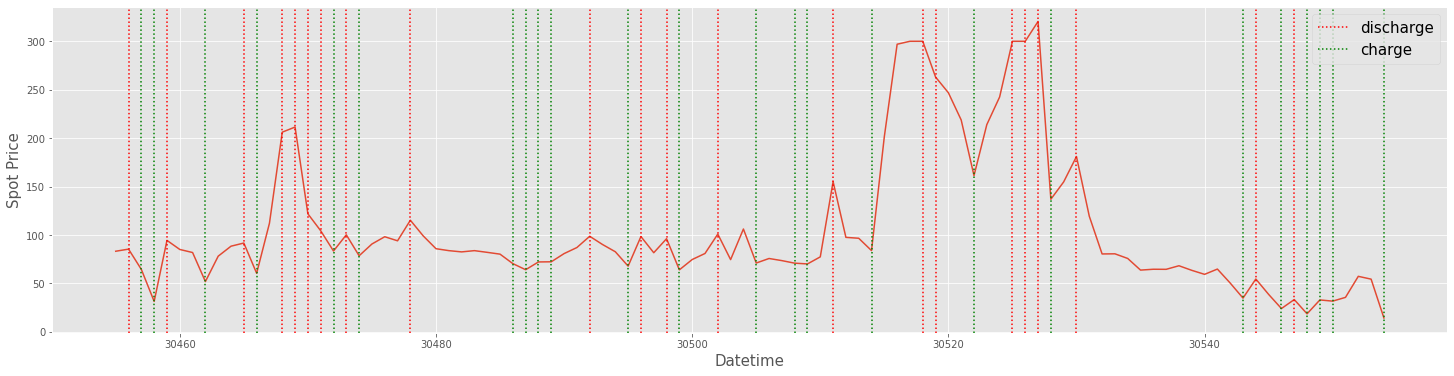

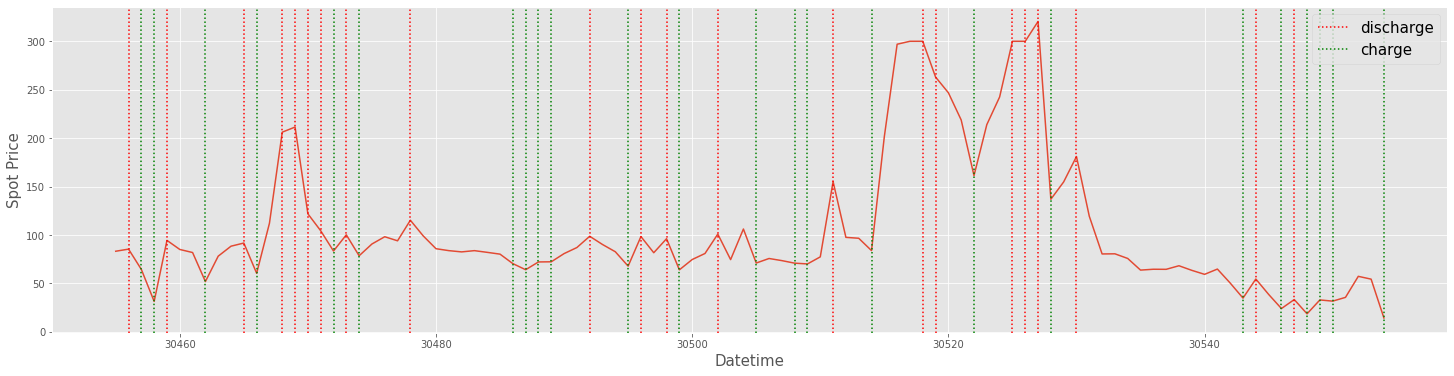

In [45]:
start = 30455  #30455
end =30555 #30555
plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)
plot_actions(df_train.spot_price, df_train.raw_power, start=start, end=end)


In [46]:
df_train[30510:30530+1]

,spot_price,period,year,forecast,percentage,raw_power,market_dispatch,market_revenue,closing_capacity
30510,77.45,32.00,2019.00,0.00,0.00,0.00,0.00,0.00,580.00
30511,155.15,33.00,2019.00,1.00,0.89,267.00,120.00,18450.00,447.00
30512,97.59,34.00,2019.00,0.00,0.00,0.00,0.00,0.00,447.00
30513,96.67,35.00,2019.00,0.00,0.00,0.00,0.00,0.00,447.00
30514,83.93,36.00,2019.00,-1.00,1.00,-295.56,-148.00,-12534.00,580.00
30515,201.60,37.00,2019.00,0.00,0.00,0.00,0.00,0.00,580.00
30516,296.95,38.00,2019.00,0.00,0.00,0.00,0.00,0.00,580.00
30517,299.99,39.00,2019.00,0.00,0.00,0.00,0.00,0.00,580.00
30518,299.99,40.00,2019.00,1.00,1.00,300.00,135.00,40134.00,430.00
30519,263.07,41.00,2019.00,1.00,0.89,267.00,120.00,31284.00,297.00


In [17]:
VIC = pd.read_csv('../../data/vic.csv')
data = VIC[(VIC['time'] >= "2021-06-07 00:00:00") & (VIC['time'] < "2021-06-08 00:00:00")].reset_index(drop=True)
#data.sort_values(['spot_price'])
vic = data.loc[:].reset_index(drop=True)
vic['time'] = vic['time'].astype('datetime64[ns]')
vic['year'] = vic['time'].dt.year
vic


,time,spot_price,inter_gen,demand,period,year
0,2021-06-07 00:00:00,3.03,333.19,5065,1,2021
1,2021-06-07 00:30:00,3.38,343.35,4903,2,2021
2,2021-06-07 01:00:00,-12.51,353.23,4753,3,2021
3,2021-06-07 01:30:00,-7.24,364.31,4628,4,2021
4,2021-06-07 02:00:00,-31.56,381.00,4424,5,2021
5,2021-06-07 02:30:00,-31.63,392.10,4314,6,2021
6,2021-06-07 03:00:00,-31.59,397.85,4224,7,2021
7,2021-06-07 03:30:00,-31.64,403.27,4155,8,2021
8,2021-06-07 04:00:00,-31.64,410.82,4107,9,2021
9,2021-06-07 04:30:00,-32.51,416.18,4154,10,2021


==== before more fliter===


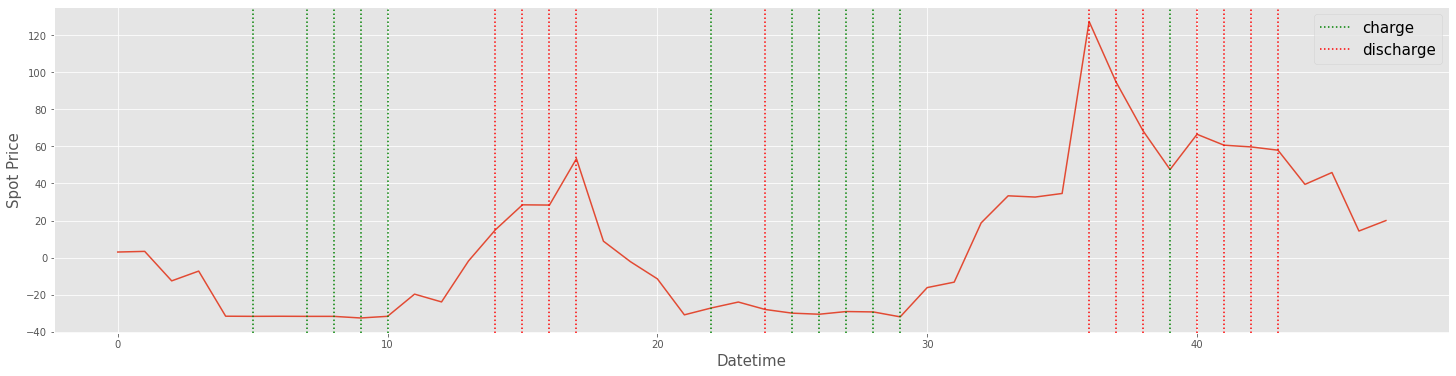

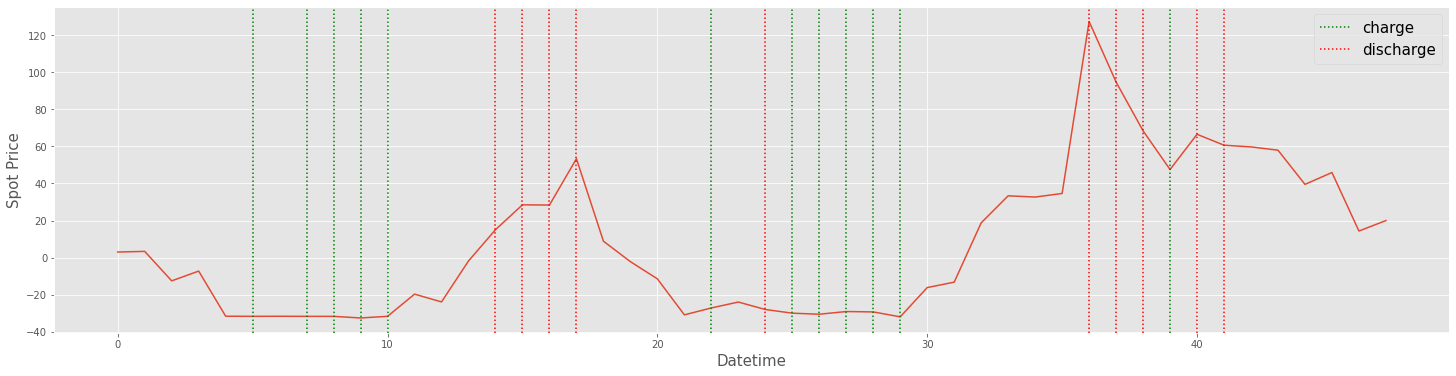

====  fliter 3 ===


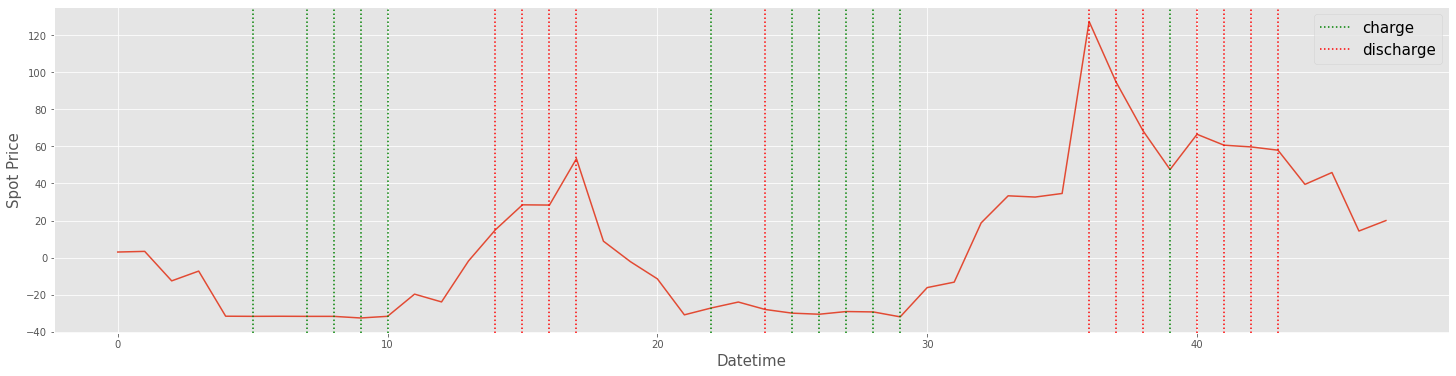

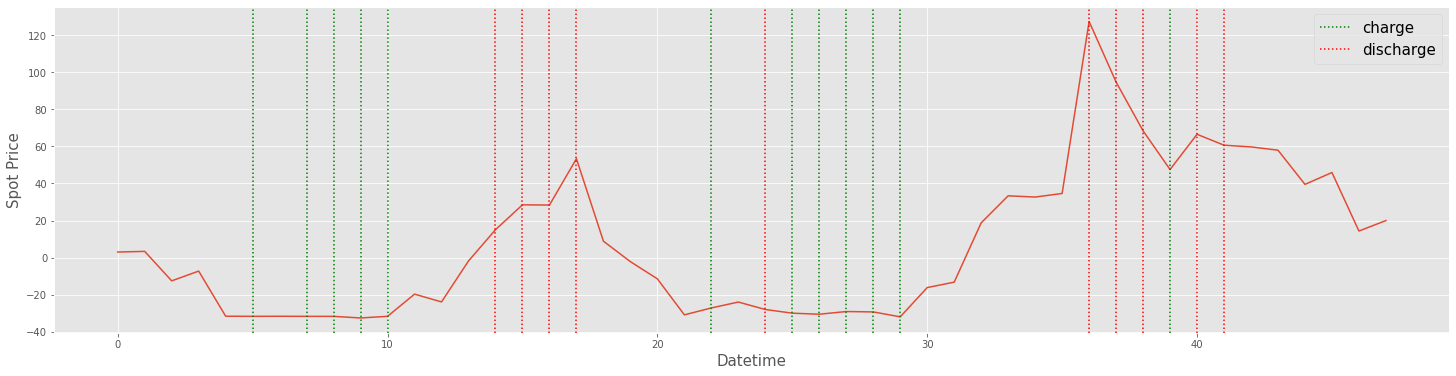

====  fliter 4 ===


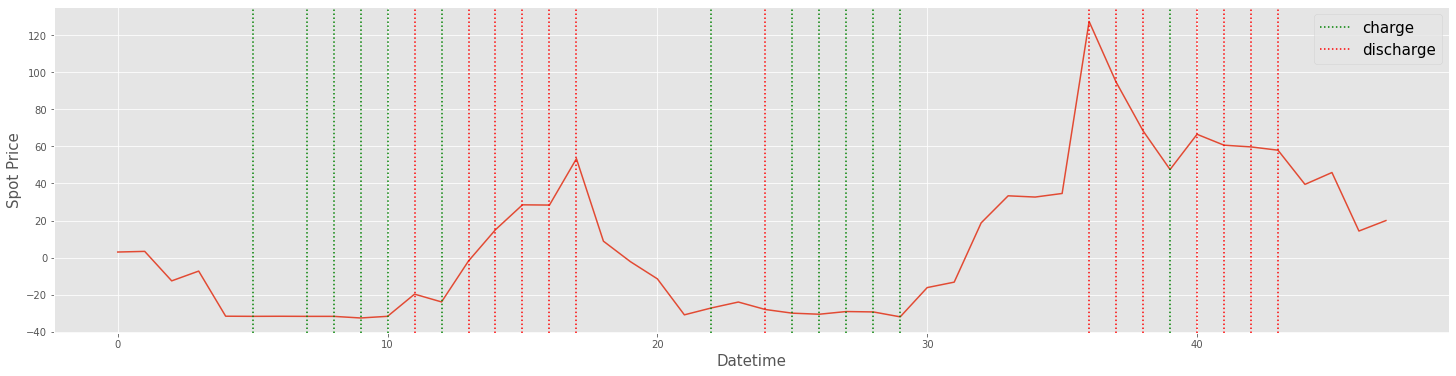

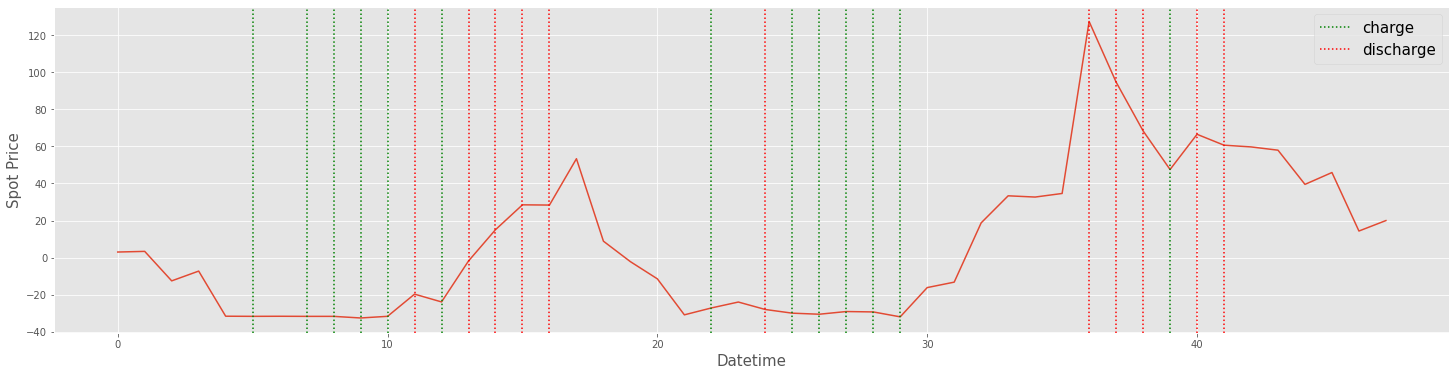

====  fliter 5 ===


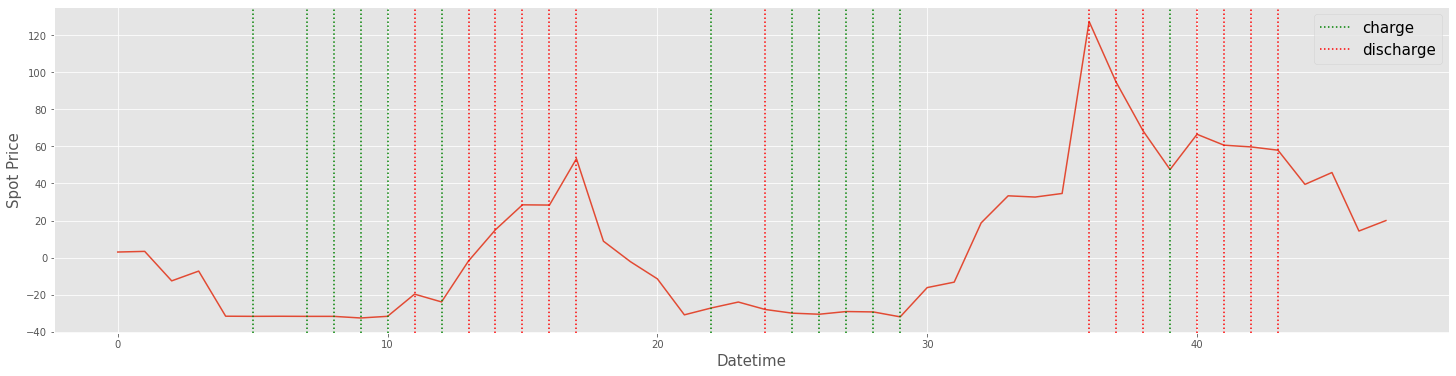

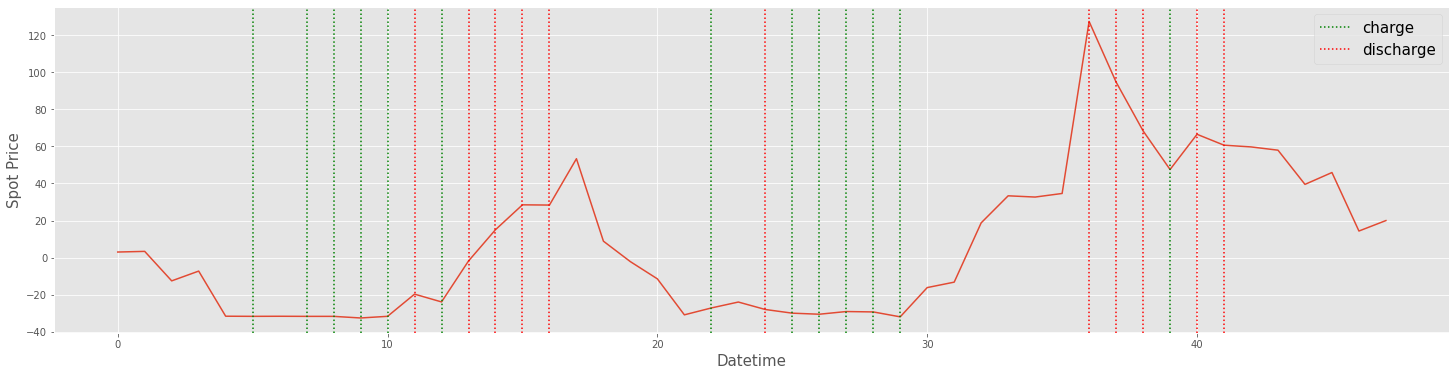

====  fliter 6 ===


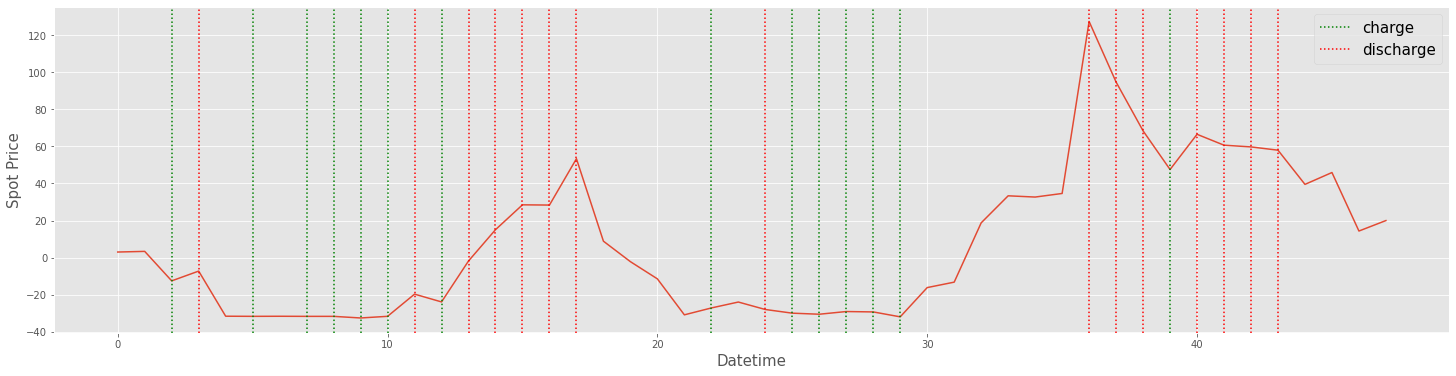

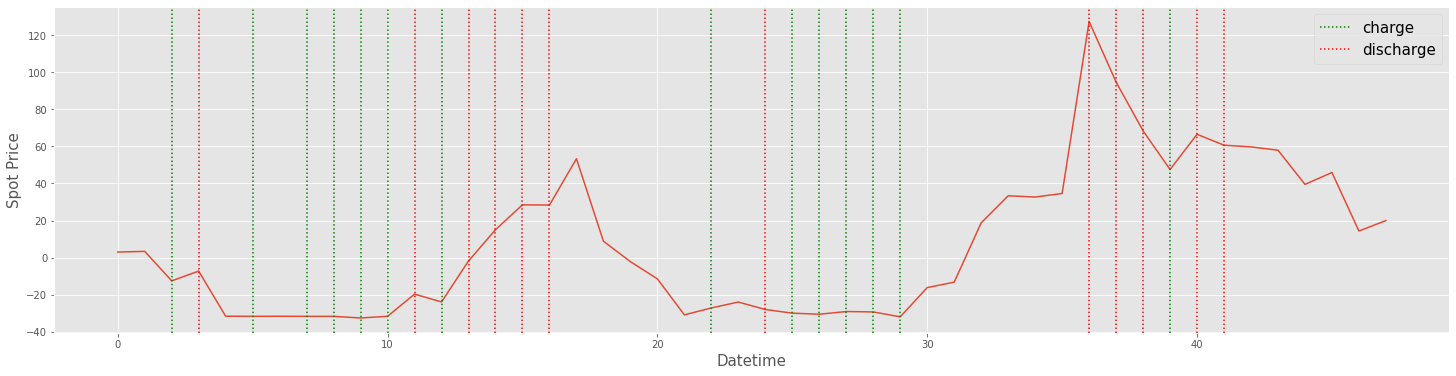

====  fliter 7 ===


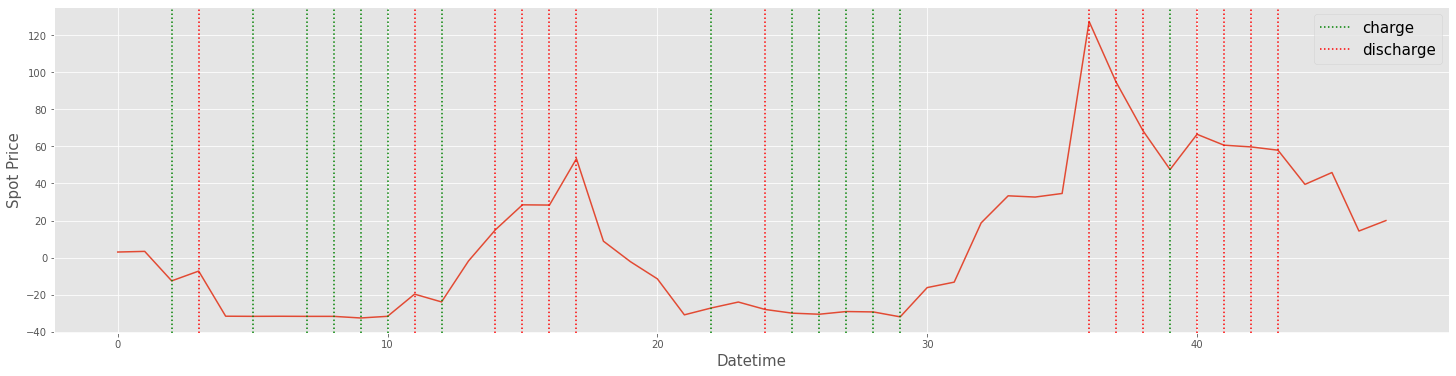

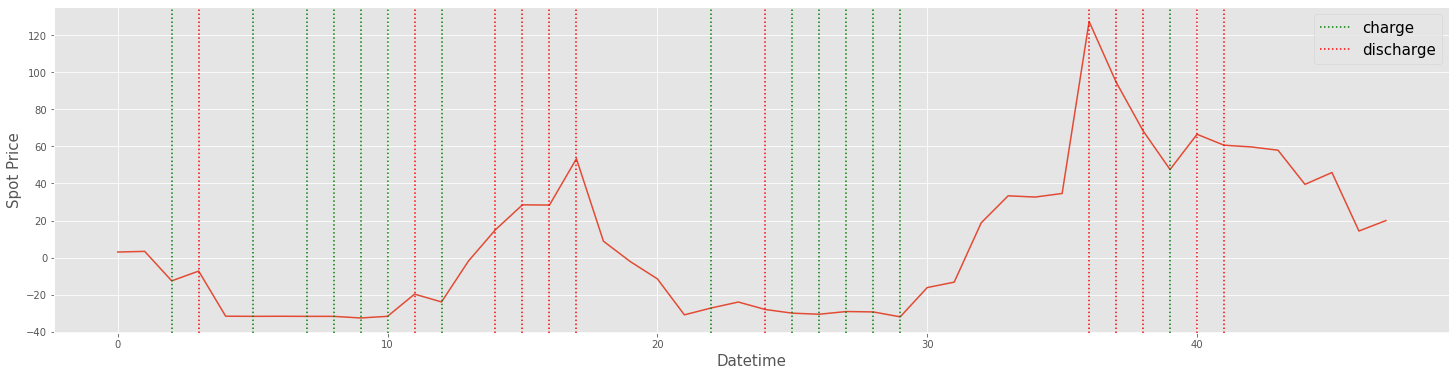

=== Algorithm Test Tom 2 (with forecast filtered & combination optimization) ===
year
2021.00   105625.00
Name: market_revenue, dtype: float64
Total Revenue: 105625.0


In [19]:

# Algo Test Tom 2 (with forecast filtered & combination optimization)
df_train = vic.copy(deep=False)[['spot_price', 'period', 'year']]
df_train['forecast'] = calc_forecast_tom_2(df_train.spot_price)


df_train['forecast'] = filter_forecast(df_train.spot_price, df_train.forecast)


df_train['forecast'] = optimize_combination(df_train.spot_price, df_train.forecast)


df_train = init_percentage(df_train)
df_train = compute_algo(df_train)
print('==== before more fliter===')
plot_actions(df_train.spot_price, df_train.forecast)
plot_actions(df_train.spot_price, df_train.raw_power)

for i in range(3):
    # more filter 3 =============
    space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] == 0)].iloc[:, [0,3,]]
    space['org_index'] = space.index
    space = space.reset_index(drop=True)
    idx = space.org_index.to_list()
    df_train.loc[idx, 'forecast'] = filter_3(space)

    df_train = set_percentage_for_fliter3(df_train)
    df_train = compute_algo(df_train)
    # end =========================

print('====  fliter 3 ===')
plot_actions(df_train.spot_price, df_train.forecast)
plot_actions(df_train.spot_price, df_train.raw_power)

# more filter 4 ===============
space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] == 580)].iloc[:, [0,3,]]
space['org_index'] = space.index
space = space.reset_index(drop=True)
idx = space.org_index.to_list()
df_train.loc[idx, 'forecast'] = filter_4(space)

df_train = set_percentage_for_fliter5(df_train)
df_train = compute_algo(df_train)


space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] >= 430)].iloc[:, [0,3,]]
space['org_index'] = space.index
space = space.reset_index(drop=True)
idx = space.org_index.to_list()
df_train.loc[idx, 'forecast'] = filter_4(space)
# end =============

df_train = set_percentage_for_fliter5(df_train)
df_train = compute_algo(df_train)

print('====  fliter 4 ===')
plot_actions(df_train.spot_price, df_train.forecast)
plot_actions(df_train.spot_price, df_train.raw_power)


for i in range(3):
    # more filter 5 ===============
    space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] >= 135)].iloc[:, [0,3,]]
    space['org_index'] = space.index
    space = space.reset_index(drop=True)
    idx = space.org_index.to_list()
    df_train.loc[idx, 'forecast'] = filter_5(space)

    df_train = set_percentage_for_fliter5(df_train)
    df_train = compute_algo(df_train)
    # end =============

print('====  fliter 5 ===')
plot_actions(df_train.spot_price, df_train.forecast)
plot_actions(df_train.spot_price, df_train.raw_power)

for i in range(3):
    # more filter 6 ===============
    space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] == 0)].iloc[:, [0,3,]]
    space['org_index'] = space.index
    space = space.reset_index(drop=True)
    idx = space.org_index.to_list()
    df_train.loc[idx, 'forecast'] = filter_6(space)

    df_train = set_percentage_for_fliter3(df_train)
    df_train = compute_algo(df_train)
    # end =============

print('====  fliter 6 ===')
plot_actions(df_train.spot_price, df_train.forecast)
plot_actions(df_train.spot_price, df_train.raw_power)

# final fliter
df_train['forecast'] = filter_forecast(df_train.spot_price, df_train.forecast)
df_train = compute_algo(df_train)

print('====  fliter 7 ===')
plot_actions(df_train.spot_price, df_train.forecast)
plot_actions(df_train.spot_price, df_train.raw_power)

print('=== Algorithm Test Tom 2 (with forecast filtered & combination optimization) ===')
print(df_train.groupby('year').market_revenue.sum())
print('Total Revenue:', df_train.market_revenue.sum())

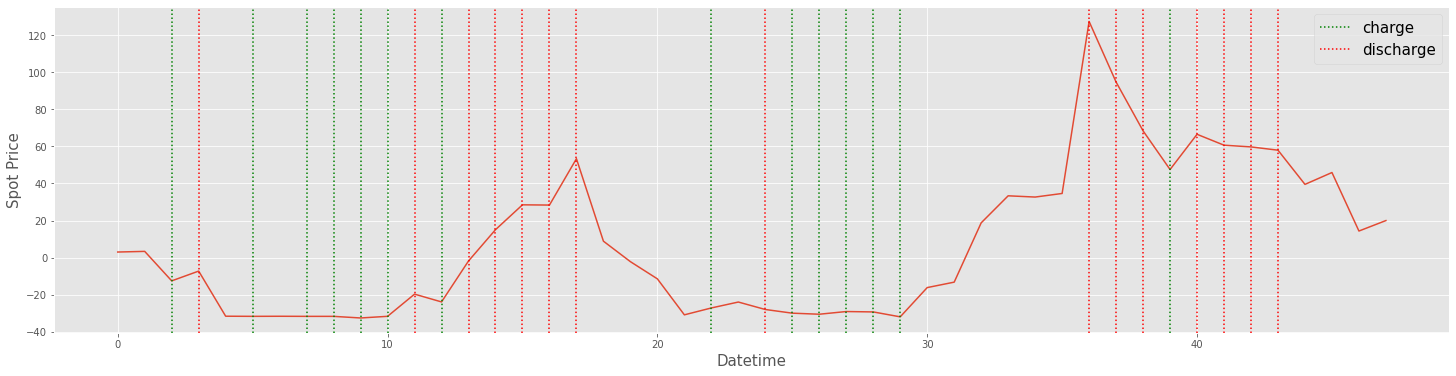

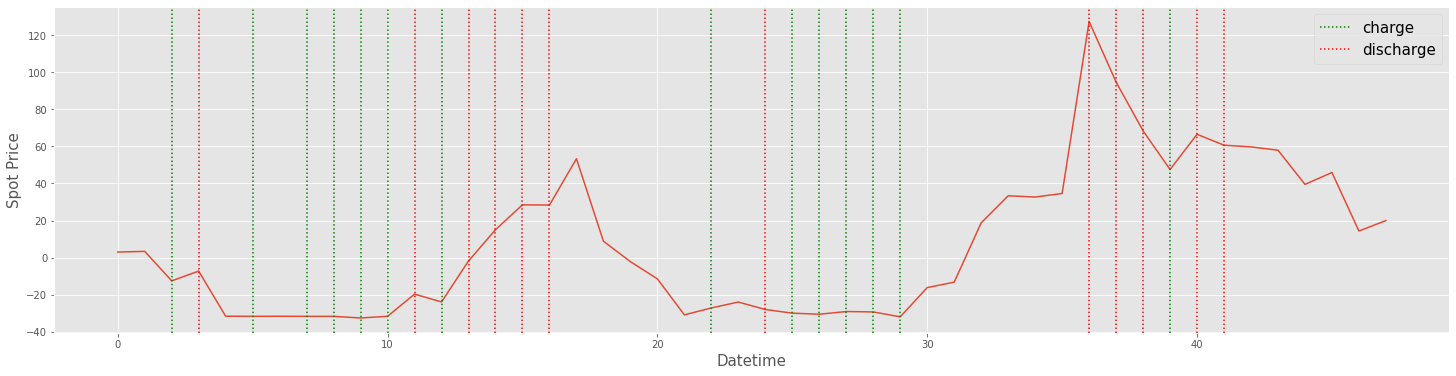

,spot_price,period,year,forecast,percentage,raw_power,market_dispatch,market_revenue,closing_capacity
0,3.03,1.00,2021.00,0.00,0.00,0.00,0.00,0.00,0.00
1,3.38,2.00,2021.00,0.00,0.00,0.00,0.00,0.00,0.00
2,-12.51,3.00,2021.00,-1.00,1.00,-300.00,-150.00,1894.00,135.00
3,-7.24,4.00,2021.00,1.00,1.00,270.00,122.00,-875.00,0.00
4,-31.56,5.00,2021.00,0.00,0.00,0.00,0.00,0.00,0.00
5,-31.63,6.00,2021.00,-1.00,1.00,-300.00,-150.00,4788.00,135.00
6,-31.59,7.00,2021.00,0.00,0.00,0.00,0.00,0.00,135.00
7,-31.64,8.00,2021.00,-1.00,1.00,-300.00,-150.00,4789.00,270.00
8,-31.64,9.00,2021.00,-1.00,1.00,-300.00,-150.00,4789.00,405.00
9,-32.51,10.00,2021.00,-1.00,1.00,-300.00,-150.00,4921.00,540.00


In [50]:
plot_actions(df_train.spot_price, df_train.forecast)
plot_actions(df_train.spot_price, df_train.raw_power)
df_train